In [1]:
import pandas as pd
import numpy as np
import datetime
from tiingo import TiingoClient
import indicoio
import seaborn as sns
import time
from textblob import TextBlob
import matplotlib as plt

In [2]:
UP = []
DOWN = []

def count_words(original_string, bag_of_words):
    split_string = original_string.lower().split()
    count = 0
    for word in bag_of_words:
        matches = split_string.count(word)
        count += matches
    ratio = count/len(split_string)
    return ratio
    
def aggregate_jsons(json_list):
    result = []
    for json in json_list:
        headline = json["title"]
        desc = json["description"]
        x = headline + " " + desc
        result.append(x)
    return result

def pipeline(df_path, ticky):
    # get the dataframe from csv
    df = pd.read_csv(df_path)
    
    # fix dates
    df["Date"] = df["Date"].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
    df["Start"] = df["Date"].apply(str)
    six_days = lambda start_date: start_date + datetime.timedelta(days=6)
    df["End"] = df["Date"].apply(six_days).apply(str)
    df = df.drop(columns=["Date"])
    remove_time = lambda dt: dt[0:10]
    df["Start"] = df["Start"].apply(remove_time)
    df["End"] = df["End"].apply(remove_time)
    
    # add json
    client = TiingoClient({"api_key": "a265fc4a1013923f970d16e7348195074e97fcb0"})
    query_ticker = lambda t, s, e: client.get_news(tickers=[t], startDate=s, endDate=e)
    df["JSON"] = df.apply(lambda d: query_ticker(ticky, d["Start"], d["End"]), axis=1)
    
    # create corpus
    df["corpus"] = df["JSON"].apply(aggregate_jsons)
    df["vectorized"] = df["corpus"]
    combinatric = lambda l: ''.join(l)
    df["corpus"] = df["vectorized"].apply(combinatric)
    
    # add sentiment
    df["sentiment"] = df["corpus"].apply(lambda orig: TextBlob(orig).sentiment.polarity)
    df["sentiment_test"] = df["vectorized"].apply(lambda orig: [TextBlob(o).sentiment.polarity for o in orig]).apply(np.mean)

    # add statistical features
    # df["features"] = df["corpus"].apply(lambda text: indicoio.text_features(text, v=2))
    
    # add bag of words ratio
    #df["bad_ratio"] = 
    #df["good_keywords"]
    
    # return the nice beautiful dataframe
    return df

In [3]:
g = time.time()
d = pipeline("TSLA-daily.csv", "tsla")
x = time.time()
d.to_csv("TSLA_vector.csv")
print("Function took {0}s to run".format(x-g))

Function took 8.802457809448242s to run


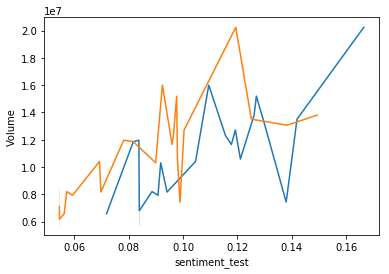

In [4]:
sns.lineplot(d["sentiment"], d["Volume"])
sns.lineplot(d["sentiment_test"], d["Volume"])

In [5]:
d.head()

,Open,High,Low,Close,Adj Close,Volume,Start,End,JSON,corpus,vectorized,sentiment,sentiment_test
0,191.199997,195.000000,187.850006,188.699997,188.699997,10312900,2019-05-28,2019-06-03,"[{'crawlDate': '2019-06-03T00:23:42.153852Z', ...",Tesla likely to build Model Y at California pl...,[Tesla likely to build Model Y at California p...,0.091818,0.089958
1,187.100006,192.389999,185.039993,189.860001,189.860001,11968600,2019-05-29,2019-06-04,"[{'crawlDate': '2019-06-04T01:36:47.939742Z', ...",UPDATE 1-Australia's Clean Teq begins search f...,[UPDATE 1-Australia's Clean Teq begins search ...,0.083808,0.078232
2,188.750000,192.259995,187.020004,188.220001,188.220001,7926500,2019-05-30,2019-06-05,"[{'crawlDate': '2019-06-04T23:36:31.276963Z', ...",Bullish Uber Analyst Isn’t Worried that Tesla ...,[Bullish Uber Analyst Isn’t Worried that Tesla...,0.090814,0.059442
3,185.100006,189.919998,184.100006,185.160004,185.160004,10406700,2019-05-31,2019-06-06,"[{'crawlDate': '2019-06-05T21:38:25.965970Z', ...",Tesla's European Demand Problems Offer a Stark...,[Tesla's European Demand Problems Offer a Star...,0.104620,0.069325
4,185.509995,186.679993,176.990005,178.970001,178.970001,13064400,2019-06-03,2019-06-09,"[{'crawlDate': '2019-06-09T00:22:46.167832Z', ...","Tesla ""Party Mode"" Coming Soon, Spotted By Hac...","[Tesla ""Party Mode"" Coming Soon, Spotted By Ha...",0.130079,0.138233


In [6]:
g = time.time()
d = pipeline("MSFT-daily.csv", "msft")
d.to_csv("MSFT_vector.csv")
x = time.time()
print("Function took {0}s to run".format(x-g))

Function took 9.515564918518066s to run


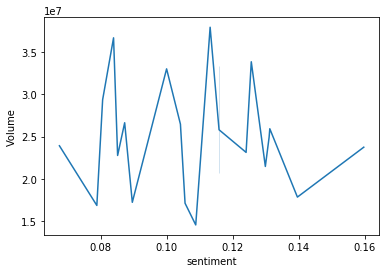

In [7]:
sns.lineplot(d["sentiment"], d["Volume"])

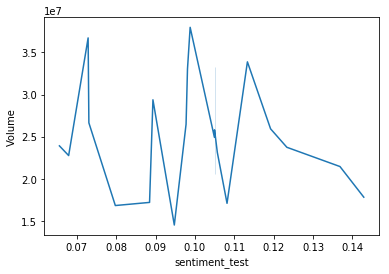

In [8]:
sns.lineplot(d["sentiment_test"], d["Volume"])

In [9]:
np.mean(d["sentiment_test"] - d["sentiment"])

-0.008986025802126036

Function took 8.657402038574219s to run


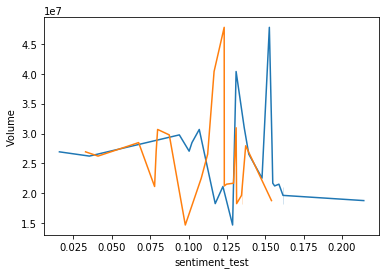

In [10]:
g = time.time()
d = pipeline("AAPL-daily.csv", "aapl")
d.to_csv("AAPL_vector.csv")
x = time.time()
print("Function took {0}s to run".format(x-g))
sns.lineplot(d["sentiment"], d["Volume"])
sns.lineplot(d["sentiment_test"], d["Volume"])

In [47]:
# d is now the AAPL vector, close will the the label
from sklearn.model_selection import train_test_split
from sklearn import linear_model

X = d[["sentiment", "sentiment_test", "Low"]]
Y = d["High"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 69)

def mse(v1, v2):
    return np.sum((v1 - v2) ** 2) 

In [48]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
Y_predicted = model.predict(X_test)
error = mse(Y_predicted, Y_test)
print("Error was {0}".format(error))

Error was 45.32821320564766


In [49]:
np.mean(abs(Y_predicted - Y_test))

1.7353932979010707

In [50]:
pd.DataFrame(Y_predicted, Y_test)

,0
High,
227.770004,229.301422
222.179993,222.564504
216.649994,220.300726
211.000000,212.224420
192.259995,190.969385
234.740005,234.790662
227.000000,225.179708
189.919998,188.442708
225.860001,228.563667


In [35]:
def predictor(data):
    data = 
    from sklearn.model_selection import train_test_split
    from sklearn import linear_model

    X = d[["sentiment", "sentiment_test", "Open"]]
    Y = d["Close"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 69)

    def mse(v1, v2):
        return np.sum((v1 - v2) ** 2) 
    
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    Y_predicted = model.predict(X_test)
    error = mse(Y_predicted, Y_test)
    print("Error was {0}".format(error))

In [41]:
d = pd.read_csv("TSLA_vector.csv")
d.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Start,End,JSON,corpus,vectorized,sentiment,sentiment_test
0,0,191.199997,195.000000,187.850006,188.699997,188.699997,10312900,2019-05-28,2019-06-03,"[{'crawlDate': '2019-06-03T00:23:42.153852Z', ...",Tesla likely to build Model Y at California pl...,['Tesla likely to build Model Y at California ...,0.091818,0.089958
1,1,187.100006,192.389999,185.039993,189.860001,189.860001,11968600,2019-05-29,2019-06-04,"[{'crawlDate': '2019-06-04T01:36:47.939742Z', ...",UPDATE 1-Australia's Clean Teq begins search f...,"[""UPDATE 1-Australia's Clean Teq begins search...",0.083808,0.078232
2,2,188.750000,192.259995,187.020004,188.220001,188.220001,7926500,2019-05-30,2019-06-05,"[{'crawlDate': '2019-06-04T23:36:31.276963Z', ...",Bullish Uber Analyst Isn’t Worried that Tesla ...,['Bullish Uber Analyst Isn’t Worried that Tesl...,0.090814,0.059442
3,3,185.100006,189.919998,184.100006,185.160004,185.160004,10406700,2019-05-31,2019-06-06,"[{'crawlDate': '2019-06-05T21:38:25.965970Z', ...",Tesla's European Demand Problems Offer a Stark...,"[""Tesla's European Demand Problems Offer a Sta...",0.104620,0.069325
4,4,185.509995,186.679993,176.990005,178.970001,178.970001,13064400,2019-06-03,2019-06-09,"[{'crawlDate': '2019-06-09T00:22:46.167832Z', ...","Tesla ""Party Mode"" Coming Soon, Spotted By Hac...","['Tesla ""Party Mode"" Coming Soon, Spotted By H...",0.130079,0.138233


In [42]:
predictor(d)

Error was 404.024380296339
